In [27]:
import matplotlib.pyplot as plt
import numpy


def generate(data_length, odes, state, parameters):
    data = numpy.zeros([state.shape[0], data_length])

    for i in range(5000):
        state = rk4(odes, state, parameters)

    for i in range(data_length):
        state = rk4(odes, state, parameters)
        data[:, i] = state

    return data


def rk4(odes, state, parameters, dt=0.01):
    k1 = dt * odes(state, parameters)
    k2 = dt * odes(state + 0.5 * k1, parameters)
    k3 = dt * odes(state + 0.5 * k2, parameters)
    k4 = dt * odes(state + k3, parameters)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def lorenz_odes(state, parameters):
    x,y,z=state
    sigma, beta, rho=parameters
    return numpy.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def lorenz_generate(data_length):
    return generate(data_length, lorenz_odes, \
        numpy.array([-8.0, 8.0, 27.0]), numpy.array([10.0, 8/3.0, 28.0]))

# def henon_map(x0,y0,size,a=1.4,b=0.3):

# 	for size
# 	x=




import math
import mpl_toolkits.mplot3d.axes3d as axes3d 

def plot3d(xyz,title=None):
    figure = plt.figure()
    axes = axes3d.Axes3D(figure)
    axes.plot3D( xyz[0], xyz[1],xyz[2])

    figure.add_axes(axes)
    plt.title(title)
    plt.show(block=False)

def plot2d(xy,title=None):
    plt.plot(xy[0], xy[1])
    plt.title(title)
    plt.show(block=False)

def remove_tail(serie,tail_size):
    if tail_size>0:
        return serie[:-tail_size]
    else:
        return serie[:]

def create_lagged_series(serie,qtd,lag_size=2):
    """
    Baseado no Takens Embedding Theorem
    :param serie: uma serie temporal
    :param lag_size: tamanho do atraso, também conhecido como tau
    :param qtd: número de séries 
    :returns: uma lista de séries atrasadas 
    """
    series=[]
    tail_size=(qtd-1)*lag_size

    for i in range(qtd):
        series.append(remove_tail(numpy.roll(serie, -i*lag_size),tail_size))

    # import ipdb;ipdb.set_trace()
    return series


def heaviside_step(v):
    ret=0
    if v>0 :
        ret=1

    return ret

def norm(a,b):
    s=0
    for i in range(len(a)):
        s+=(a[i]-b[i])**2

    return math.sqrt(s)




def correlation(series, r,n):
    s=len(series)
    somatorio=0
    for i in range(n):
        for j in range(n):
            ti=[]
            tj=[]
            for k in range(s):
                ti.append(series[k][i])
                tj.append(series[k][j])
            # print("ti",ti)
            # print("tj",tj)

            somatorio+=heaviside_step(r-norm(ti,tj))

    c=(2/float((n*(n-1))))+somatorio
    return c;



def is_like(a,b,limiar=0.5):
    k=abs(a-b)
    print("k",k)
    print("limiar",limiar)

    return k<=abs(limiar)

def find_saturation(m_list,v_list):
    v_list_len=len(v_list)
    m_list_len=len(m_list)

    if v_list_len!=m_list_len:
        raise ValueError("listas de tamanhos diferentes")

    if v_list_len<2:
        raise ValueError("lista menor menor que 2 ")

    print("m_list",m_list)
    print("v_list",v_list)

    m=None
    v_old=v_list[0]

    for i,v in enumerate(v_list[1:]):

        if is_like(v,v_old,v/100.0):
            m=m_list[max(0,i-1)]

            break
        v_old=v_list[i]

    return m



import numpy as np
def calc_attractor_dimension(serie,dim_min=1,dim_max=20):
    """
    Baseado no Grassberger-Procaccia Algorithm
    :param serie: uma serie temporal
    :returns: um float com a dimensão encontrada. Ou "-1" caso não encontre 
    """
    m=dim_min
    limiar=0.5
    alpha=1
    tau=1
    is_attractor=False
    n=10
    v_list=[]
    m_list=list(range(1,dim_max+1))
    r=np.std(serie[:n])

    print("r",r)
    for m in m_list:
        lagged_series=create_lagged_series(serie,m,lag_size=tau)

        c=correlation(lagged_series, r,n)

        v_list.append(math.log10(c)/math.log10(r))


    # print("v",v)
    # print("m",m_list)


    return find_saturation(m_list,v_list) 





def find_lag(serie,max_tau=1000,limiar=0.001):

    '''encontra o atraso baseado na função do correlação. O atraso escolhido
    é o primeiro zero encontrado para função de correlação.
    :param serie: serie temporal
    :param max: maximo de iterações
    '''
    cf_first_min=1
    tau_cf_first_min=0
    tau=1
    cf_list=[]

    while tau<=max_tau:

        size=len(serie)-tau
        t=0
        a=0

        while t<size:
            a+=(serie[t]*serie[t+tau])
            t+=1

        a=a/float(size)
        t=0
        b=0

        while t<size:
            b+=serie[t]**2
            t+=1

        b=b/float(size)
        cf=(a/float(b))
        cf_list.append(cf)
        print("cf",cf)

        # if is_like(cf,0,limiar):
        # 	return cf


        if cf_first_min>abs(cf) or cf*cf_first_min<=0:
            cf_first_min=cf
            tau_cf_first_min=tau
        else:
            break;

        tau+=1


    return tau_cf_first_min,cf_list






def lyap_from_serie(serie):

    lagged_series=create_lagged_series(serie,2,2)
    y=lagged_series[0]
    z=lagged_series[1]
    size=len(lagged_series[1])
    s=0
    k=10
    j=0
    while j<(size-k):
        L=abs(y[j]-z[j])
        L_linha=abs(y[j]-z[j+k])
        s+=math.log(L_linha/float(L),2)
        j+=k

    lyap=s/float(size)

    return  lyap


def plot1d(serie,title=""):
    plt.plot(serie)
    plt.title(title)
    plt.show(block=False)


def ex_1():
    '''
    construir uma série a partir do atrator Lorenz
    '''

    data = lorenz_generate(2**13)
    plt.plot(data[0])
    plt.title("série obtida a partir do  do atrator de Lorenz")
    plt.show(block=False)

    # data = henon_generate(2**13)
    # plt.plot(data[0])
    # plt.title("série obtida a partir do mapa de henon")
    # plt.show(block=False)



def ex_2():
    '''
    construir o atrator de Lorenz a partir da série temporal obtida no exercício anterior
    '''

    # serie a partir do atrator de Lorenz, repare que data é apenas a dimensão x do atrator
    atrator_3d = lorenz_generate(2**14)

    plot3d(atrator_3d,"Atrator original")

    #pegamos uma dimensão do atrator
    atrator_d0=atrator_3d[0]


    #por que esse valor? Aqui foi arbitrário. Existem métodos para isso, não explorados aqui 
    tau=3;

    #a partir de 1 dimensão do atrator, criamos 3 séries com atraso 0,tau, 2*tau
    # data_lag0 = atrator_d0

    # data_lag1 = numpy.roll(data_lag0, -tau)[:-tau]

    # data_lag2 = numpy.roll(data_lag1, -tau)[:-tau]

    # #imprime o atrator, pronto. Reconstruído
    # plot3d([data_lag0[:-2*tau], data_lag1[:-tau], data_lag2],"Atrator reconstruído")
    lagged_series=create_lagged_series(atrator_d0,3,tau)
    plot3d(lagged_series,"Atrator reconstruído")

def ex_3(choose_dim=0):
    '''
    calcular dimensão do atrator a partir da serie de Lorenz
    '''



    # serie a partir do atrator de Lorenz, repare que data é apenas a dimensão x do atrator
    atrator_3d = lorenz_generate(2**14)

    # plot3d(atrator_3d,"Atrator original")

    #pegamos uma dimensão do atrator
    atrator_d0=atrator_3d[choose_dim]

    d=calc_attractor_dimension(atrator_d0)

    if d!=None:
        print("dimension:",d)
    else:
        print("dimension not found")


def ex_4():
    '''
    agora com uma série de um experimento com pêndulo de http://lamastex.org/lmse/double-pendulum/
    '''
    import csv
    csv_file=open("divergence_piers2.csv",newline='')
    reader=csv.reader(csv_file,delimiter=" ")
    csv_values=[]
    for row in reader:
        if  row[0][0]!="#":
            try:
                csv_values.append(list(map(float,row[:-1])))
            except:
                raise ValueError("problema na conversão desta linha:"+str(row))

    serie=[]
    for row in csv_values[1:]:
        serie.append(row[3])


    # plot1d(serie)

    d=calc_attractor_dimension(serie)

    series=create_lagged_series(serie,2,2)

    plot2d(series)

    if d!=None:
        print("dimension:",d)
    else:
        print("dimension not found")

def ex_5():
    '''
    encontra o atraso "tau" através da função de correlação
    '''

    # serie a partir do atrator de Lorenz, repare que data é apenas a dimensão x do atrator
    atrator_3d = lorenz_generate(2**14)

    # plot3d(atrator_3d,"Atrator original")

    #pegamos uma dimensão do atrator
    atrator_d0=atrator_3d[0]
    tau,cf_list=find_lag(atrator_d0)

    print("tau:",tau)
    plot1d(cf_list,"função de correlação")

def ex_6():
    '''
    calcula o lyapunov para uma série
    '''
    # serie a partir do atrator de Lorenz, repare que data é apenas a dimensão x do atrator
    atrator_3d = lorenz_generate(2**14)

    # plot3d(atrator_3d,"Atrator original")

    #pegamos uma dimensão do atrator
    serie=atrator_3d[0]


    lyap=lyap_from_serie(serie)

    print("lyapunov da série",lyap)

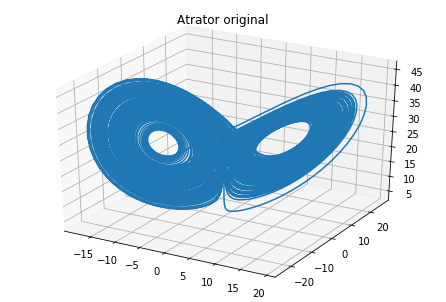

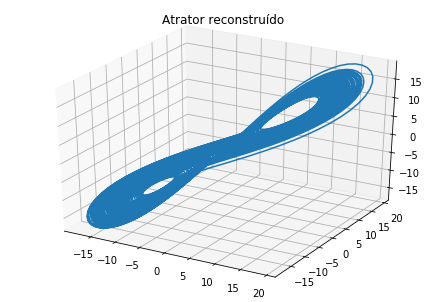

In [60]:
ex_2()

In [35]:
atrator_3d = lorenz_generate(2**14)
atrator_d0=atrator_3d[0]
calc_attractor_dimension(atrator_d0)

r 1.4457369674451328
m_list [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
v_list [10.503152924916984, 9.56817732554579, 9.041845387912842, 9.041845387912842, 9.041845387912842, 9.041845387912842, 9.041845387912842, 8.62401984651128, 7.844424641764459, 7.5253177811515615, 7.5253177811515615, 7.5253177811515615, 7.5253177811515615, 7.5253177811515615, 7.5253177811515615, 6.25253602380364, 6.25253602380364, 6.25253602380364, 6.25253602380364, 6.25253602380364]
k 0.9349755993711941
limiar 0.0956817732554579
k 1.4613075370041422
limiar 0.09041845387912842
k 0.526331937632948
limiar 0.09041845387912842
k 0.0
limiar 0.09041845387912842


3

In [36]:
import pandas as pd

In [37]:
gold = pd.read_csv("golden_usd.csv")

In [113]:
create_lagged_series(gold.price.values,1,1)

[array([  34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,
          34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.72 ,
          34.72 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,
          34.72 ,   34.71 ,   34.71 ,   34.71 ,   34.73 ,   34.66 ,
          34.49 ,   34.49 ,   34.68 ,   34.82 ,   34.73 ,   34.53 ,
          34.57 ,   34.58 ,   34.51 ,   34.63 ,   34.72 ,   34.79 ,
          34.88 ,   34.95 ,   34.92 ,   34.93 ,   34.9  ,   34.89 ,
          34.91 ,   34.91 ,   34.76 ,   34.79 ,   34.86 ,   34.85 ,
          34.86 ,   34.88 ,   34.92 ,   35.04 ,   35.08 ,   35.07 ,
          35.08 ,   35.05 ,   35.08 ,   35.08 ,   35.06 ,   35.04 ,
          35.04 ,   35.05 ,   35.06 ,   35.05 ,   35.05 ,   35.04 ,
          35.05 ,   35.03 ,   34.98 ,   34.98 ,   34.98 ,   34.97 ,
          34.99 ,   34.99 ,   34.99 ,   34.98 ,   34.99 ,   34.98 ,
          35.   ,   35.02 ,   35.01 ,   35.02 ,   34.98 ,   34.9  ,
          34.88 ,   34.89 ,   34.91 ,   34.92 , 

In [38]:
calc_attractor_dimension(gold.price,dim_min=1,dim_max=20)

r 7.105427357601002e-15
m_list [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
v_list [-0.14136546283097612, -0.14136546283097612, -0.1352753814024667, -0.1286144636916115, -0.12129906644217742, -0.11324956105482131, -0.10442465665948958, -0.09491251384801731, -0.08514898623215209, -0.07633258909568384, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588, -0.07074745801969588]
k 0.0
limiar -0.0014136546283097613


1

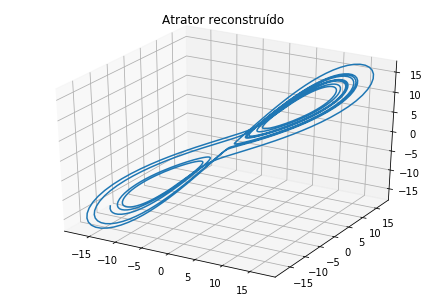

In [124]:
#atrator_d0=gold.price
atrator_d0=lorenz_generate(1000)[0]


#por que esse valor? Aqui foi arbitrário. Existem métodos para isso, não explorados aqui 
tau=3;

#a partir de 1 dimensão do atrator, criamos 3 séries com atraso 0,tau, 2*tau
# data_lag0 = atrator_d0

# data_lag1 = numpy.roll(data_lag0, -tau)[:-tau]

# data_lag2 = numpy.roll(data_lag1, -tau)[:-tau]

# #imprime o atrator, pronto. Reconstruído
# plot3d([data_lag0[:-2*tau], data_lag1[:-tau], data_lag2],"Atrator reconstruído")
lagged_series=create_lagged_series(atrator_d0,3,3)
plot3d(lagged_series,"Atrator reconstruído")

In [118]:
lagged_series

[array([  34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,
          34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.72 ,
          34.72 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,   34.73 ,
          34.72 ,   34.71 ,   34.71 ,   34.71 ,   34.73 ,   34.66 ,
          34.49 ,   34.49 ,   34.68 ,   34.82 ,   34.73 ,   34.53 ,
          34.57 ,   34.58 ,   34.51 ,   34.63 ,   34.72 ,   34.79 ,
          34.88 ,   34.95 ,   34.92 ,   34.93 ,   34.9  ,   34.89 ,
          34.91 ,   34.91 ,   34.76 ,   34.79 ,   34.86 ,   34.85 ,
          34.86 ,   34.88 ,   34.92 ,   35.04 ,   35.08 ,   35.07 ,
          35.08 ,   35.05 ,   35.08 ,   35.08 ,   35.06 ,   35.04 ,
          35.04 ,   35.05 ,   35.06 ,   35.05 ,   35.05 ,   35.04 ,
          35.05 ,   35.03 ,   34.98 ,   34.98 ,   34.98 ,   34.97 ,
          34.99 ,   34.99 ,   34.99 ,   34.98 ,   34.99 ,   34.98 ,
          35.   ,   35.02 ,   35.01 ,   35.02 ,   34.98 ,   34.9  ,
          34.88 ,   34.89 ,   34.91 ,   34.92 , 

In [109]:
def lyap_from_serie(serie):

    lagged_series=create_lagged_series(serie,2,2)
    y=lagged_series[0]
    z=lagged_series[1]
    size=len(lagged_series[1])
    s=0
    k=10
    j=0
    while j<(size-k):
        L=abs(y[j]-z[j])
        L_linha=abs(y[j]-z[j+k])
        s+=math.log((L_linha+1e-6)/float(L+1e-6), 2)
        j+=k

    lyap=s/float(size)

    return  lyap

In [111]:
lyap_from_serie(np.random.rand(100))

0.027543597486999537

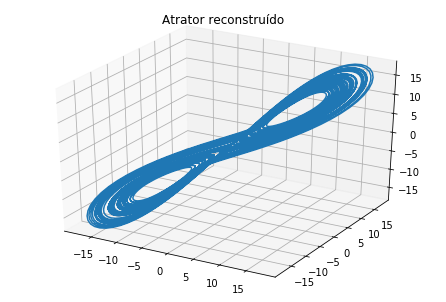

In [26]:
atrator_d0=lorenz_generate(2**13)[0,:]


#por que esse valor? Aqui foi arbitrário. Existem métodos para isso, não explorados aqui 
tau=3;

#a partir de 1 dimensão do atrator, criamos 3 séries com atraso 0,tau, 2*tau
# data_lag0 = atrator_d0

# data_lag1 = numpy.roll(data_lag0, -tau)[:-tau]

# data_lag2 = numpy.roll(data_lag1, -tau)[:-tau]

# #imprime o atrator, pronto. Reconstruído
# plot3d([data_lag0[:-2*tau], data_lag1[:-tau], data_lag2],"Atrator reconstruído")
lagged_series=create_lagged_series(atrator_d0,9,tau)
plot3d(lagged_series,"Atrator reconstruído")